In [1]:
import os
import shutil
os.environ['OMPI_MCA_rmaps_base_oversubscribe'] = '1'
n_threads = 96
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_THREADS'] = f'{n_threads}'
os.environ['NUMEXPR_NUM_THREADS'] = f'{n_threads}'
os.environ['OMP_THREAD_LIMIT'] = f'{n_threads}'
os.environ["OMP_NUM_THREADS"] = f'{n_threads}'
os.environ["OPENBLAS_NUM_THREADS"] = f'{n_threads}' # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = f'{n_threads}' # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = f'{n_threads}' # export VECLIB_MAXIMUM_THREADS=4
import gc
from datetime import datetime
from osgeo import gdal, gdal_array
from pathlib import Path
from typing import Callable, Iterator, List,        Union
import bottleneck as bn
import geopandas as gpd
import numpy as np
import pandas as pd
import skmap_bindings as sb
import tempfile
import time
import sys
import csv
from scipy.signal import savgol_coeffs
import numpy as np
from skmap.io import process
import matplotlib.pyplot as plt
from mpi4py import MPI
import random

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}

co = ['TILED=YES', 'BIGTIFF=YES', 'COMPRESS=DEFLATE', 'BLOCKXSIZE=1024', 'BLOCKYSIZE=1024']

executor = None

def ttprint(*args, **kwargs):
    from datetime import datetime
    import sys

    print(f'[{datetime.now():%H:%M:%S}] ', end='')
    print(*args, **kwargs, flush=True)

def make_tempdir(basedir='skmap', make_subdir = True):
    tempdir = Path(TMP_DIR).joinpath(basedir)
    if make_subdir: 
        name = Path(tempfile.NamedTemporaryFile().name).name
        tempdir = tempdir.joinpath(name)
    tempdir.mkdir(parents=True, exist_ok=True)
    return tempdir

def make_tempfile(basedir='skmap', prefix='', suffix='', make_subdir = False):
    tempdir = make_tempdir(basedir, make_subdir=make_subdir)
    return tempdir.joinpath(
        Path(tempfile.NamedTemporaryFile(prefix=prefix, suffix=suffix).name).name
    )
    
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row    

def apllaySWAG(data_in, att_env, att_seas, season_size, future_scaling):
    n_s = data_in.shape[0]
    w_p = (get_SWAG_weights(att_env, att_seas, season_size, n_s)[1:][::-1]).astype(np.float32)
    w_f = (get_SWAG_weights(att_env, att_seas, season_size, n_s)[1:]).astype(np.float32)*future_scaling
    w_0 = 1.0
    out_index_offset = 0
    data_in_t = np.empty((data_in.shape[1], data_in.shape[0]), dtype=np.float32)
    data_rec_t = np.empty((data_in.shape[1], data_in.shape[0]), dtype=np.float32)
    data_rec = np.empty(data_in.shape, dtype=np.float32)
    sb.transposeArray(data_in, n_threads, data_in_t)
    sb.applyTsirf(data_in_t, n_threads, data_rec_t, out_index_offset, w_0, w_p, w_f, True, "v2", backend)
    sb.transposeArray(data_rec_t, n_threads, data_rec)
    return data_rec

def apllaySavitzkyGolay(data_in, w_l, p_o):
    SG_coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
    w_0_SG = SG_coef[w_l].astype(np.float32)
    w_f_SG = SG_coef[w_l+1:].astype(np.float32)
    w_p_SG = SG_coef[0:w_l].astype(np.float32)
    data_in_t = np.empty((data_in.shape[1], data_in.shape[0]), dtype=np.float32)
    data_rec_t = np.empty((data_in.shape[1], data_in.shape[0]), dtype=np.float32)
    data_rec = np.empty(data_in.shape, dtype=np.float32)
    sb.transposeArray(data_in, n_threads, data_in_t)
    sb.convolveRows(data_in_t, n_threads, data_rec_t, w_0_SG, w_p_SG, w_f_SG)
    sb.transposeArray(data_rec_t, n_threads, data_rec)
    return data_rec

years = range(2020,2023)
x_size, y_size = (4004, 4004)
x_off, y_off = (0,0)
n_pix = x_size * y_size
no_data = 0
bands_list = [1,]
file_ending = '_go_epsg.4326_v20240521.tif'
n_imag_per_year = 23
n_imag_per_year_agg = 12
out_index_offset = 0
n_years = len(years)
n_s = n_years*n_imag_per_year
n_s_agg = n_years*n_imag_per_year_agg

backend = 'Matrix'

bands_prefix = ['red_glad',
                'nir_glad',
                'qa_mask']

doy_start = ['0101', '0117', '0202', '0218', '0305', '0321', '0406', '0422', '0508', '0524', '0609',
             '0625', '0711', '0727', '0812', '0828', '0913', '0929', '1015', '1031', '1116', '1202', '1218']

doy_end = ['0116', '0201', '0217', '0304', '0320', '0405', '0421', '0507', '0523', '0608', '0624',
           '0710', '0726', '0811', '0827', '0912', '0928', '1014', '1030', '1115', '1201', '1217', '1231']


month_start = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
month_end = ['0131', '0228', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']



att_env, att_seas, future_scaling = (20.0, 40.0, 0.1)
w_l, p_o = (2, 2)
diff_th = 35
count_th = int(n_s/4)
# tiles = ['009E_04N', '009E_51N', '013E_61N', '050W_07S', '085W_52N', '091W_37N', '115E_03S', '127E_42N']
# tiles =                  ['009E_51N', '013E_61N', '127E_42N', 052W_19S] # ready tiles
# respective_MODIS_tile = ['?',         'h18v02',    '?',       'h13v10'] # ready tiles
# Command to copy MODIS data "seq 2000 2023 | xargs -I {} echo "mc find gaia/tmp-mod13q1.061-tif/{}/h18v02" | bash | grep ndvi | xargs -I {} echo "mc cp {} ." | parallel -j30"
# Command to rename MODIS files "for file in MOD13Q1.*.tif; do mv "$file" "$(echo "$file" | sed 's/\.[0-9]\{13\}//')"; done"
landsat_tile = '051W_18S'
modis_tile = 'h13v10' # ready tiles

# for landsat_tile, modis_tile in zip(landsat_tiles, modis_tiles):

ttprint(f"Processing tile {landsat_tile}")

landsat_files = []
modis_files = []
for b in bands_prefix:
    for year in years:
        for m in range(n_imag_per_year):
            # landsat_files.append(f'http://192.168.49.{random.randint(30,44)}:8333/prod-landsat-ard2/{landsat_tile}/raw/{b}.ard2_m_30m_s_{year}{doy_start[m]}_{year}{doy_end[m]}{file_ending}')
            landsat_files.append(f'data_16days/{landsat_tile}/{b}.ard2_m_30m_s_{year}{doy_start[m]}_{year}{doy_end[m]}{file_ending}')
for year in years:
    if year < 2000:
        year = 2000
    for m in range(23):
        if (year == 2000) & (m < 3):
            m = 3
        if (year == 2021) & (m == 17):
            m = 16
        if (year == 2016) & (m == 22):
            m = 21
        if (year == 2022) & (m == 0):
            m = 1
        modis_files.append(f'data_16days/{modis_tile}/MOD13Q1.A{year}{str(1+16*m).zfill(3)}.{modis_tile}.061_ndvi.tif')

landsat_data = np.empty((n_s*4, n_pix), dtype=np.float32)
modis_data = np.empty((n_s, n_pix), dtype=np.float32)

start = time.time()
sb.readData(landsat_data, n_threads, landsat_files, range(len(landsat_files)), x_off, y_off, x_size, y_size, bands_list, gdal_opts, no_data, np.nan)
ttprint(f"Tile {landsat_tile} - Reading Landsat data: {(time.time() - start):.2f} segs")

start = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
if size != 1:
    print("This example requires exactly one parent process.")
    comm.Abort(1)
n_proc = n_s

landsat_args = ",".join(landsat_files)
modis_args = ",".join(modis_files)
other_args = [str(n_threads), str(n_pix), "GRA_NearestNeighbour"]

# Write arguments to a temporary file
with open('args.txt', 'w') as f:
    f.write('\n'.join([landsat_args, modis_args] + other_args))
    
intercomm = MPI.COMM_SELF.Spawn(
    sys.executable, 
    args=['child.py', 'args.txt'], 
    maxprocs=n_proc
)
# intercomm = MPI.COMM_SELF.Spawn(
#     sys.executable, args=['child.py', ",".join(landsat_files), ",".join(modis_files), str(n_threads), str(n_pix), "GRA_NearestNeighbour"], maxprocs=n_proc)
for i in range(n_proc):
    received_array = np.empty(n_pix, dtype=np.float32)
    intercomm.Recv(received_array, source=MPI.ANY_SOURCE, tag=i)
    modis_data[i, :] = received_array
ttprint(f"Tile {landsat_tile} - Reading MODIS data: {(time.time() - start):.2f} segs")
intercomm.Disconnect()
MPI.Finalize()
    


[13:42:09] Processing tile 052W_19S
[13:42:28] Tile 052W_19S - Reading Landsat data: 19.33 segs
[13:45:04] Tile 052W_19S - Reading MODIS data: 155.85 segs


In [2]:
start = time.time()
band_scaling = 1/4e4
result_scaling = 1e4
result_offset = 0.
sb.computeNormalizedDifference(landsat_data, n_threads,
                            range(n_s*1, n_s*2), range(n_s*0, n_s*1), range(n_s*3, n_s*4),
                            band_scaling, band_scaling, result_scaling, result_offset, [-1e4, 1e4])
sb.swapRowsValues(modis_data, n_threads, range(modis_data.shape[0]), -3000, np.nan)

# landsat_NDVI = np.empty((n_s, x_size * y_size), dtype=np.float32)
# sb.extractArrayRows(landsat_data, n_threads, landsat_NDVI, range(n_s*3, n_s*4))
landsat_NDVI_masked = np.empty((n_s, x_size * y_size), dtype=np.float32)
sb.extractArrayRows(landsat_data, n_threads, landsat_NDVI_masked, range(n_s*3, n_s*4))


# landsat_QA = np.empty((n_s, x_size * y_size), dtype=np.float32)
# sb.extractArrayRows(landsat_data, n_threads, landsat_QA, range(n_s*2, n_s*3))
landsat_maks_old = np.empty((n_s, x_size * y_size), dtype=np.float32)
sb.extractArrayRows(landsat_data, n_threads, landsat_maks_old, range(n_s*2, n_s*3))

gap_mask_old = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
for k in range(1,18):
    sb.swapRowsValues(landsat_maks_old, n_threads, range(modis_data.shape[0]), k, gap_mask_old[k-1])

sb.maskData(landsat_NDVI_masked, n_threads, range(landsat_NDVI_masked.shape[0]), landsat_maks_old, 1., np.nan)
ttprint(f"Tile {landsat_tile} - Process data: {(time.time() - start):.2f} segs")


[13:45:18] Tile 052W_19S - Process data: 13.58 segs


In [3]:
start = time.time()

w_p = (get_SWAG_weights(att_env, att_seas, n_imag_per_year, n_s)[1:][::-1]).astype(np.float32)
w_f = (get_SWAG_weights(att_env, att_seas, n_imag_per_year, n_s)[1:]).astype(np.float32)*future_scaling
w_0 = 1.0

modis_data_t = np.empty((n_pix, n_s), dtype=np.float32)
modis_rec_t = np.empty((n_pix, n_s), dtype=np.float32)
modis_rec = np.empty((n_s, n_pix), dtype=np.float32)
sb.transposeArray(modis_data, n_threads, modis_data_t)
sb.applyTsirf(modis_data_t, n_threads, modis_rec_t, 0, w_0, w_p, w_f, True, "v2", backend)
sb.transposeArray(modis_rec_t, n_threads, modis_rec)

landsat_NDVI_masked_t = np.empty((n_pix, n_s), dtype=np.float32)
sb.transposeArray(landsat_NDVI_masked, n_threads, landsat_NDVI_masked_t)

# landsat_NDVI_rec_t = np.empty((n_pix, n_s), dtype=np.float32)
# landsat_NDVI_rec = np.empty((n_s, n_pix), dtype=np.float32)
# sb.applyTsirf(landsat_NDVI_masked_t, n_threads, landsat_NDVI_rec_t, 0, w_0, w_p, w_f, True, "v2", backend)
# sb.transposeArray(landsat_NDVI_rec_t, n_threads, landsat_NDVI_rec)

ttprint(f"Tile {landsat_tile} - Reconstructing with SWA: {(time.time() - start):.2f} segs")

[13:46:07] Tile 052W_19S - Reconstructing with SWA: 49.59 segs


In [13]:
start = time.time()
diff_th, count_th = (3000, int(0.3*n_s))
mask_t = np.empty(landsat_NDVI_masked_t.shape, dtype=np.float32)
sb.maskDifference(landsat_NDVI_masked_t, n_threads, diff_th, count_th, modis_rec_t, mask_t)
sb.maskData(landsat_NDVI_masked_t, n_threads, range(landsat_NDVI_masked_t.shape[0]), mask_t, 1., np.nan)
ttprint(f"Tile {landsat_tile} - Get artifact mask from NDVI: {(time.time() - start):.2f} segs")

[13:53:23] Tile 052W_19S - Get artifact mask from NDVI: 11.23 segs


In [14]:
start = time.time()
masked_bands = []
for i in range(2):
    landsat_band_t = np.empty((n_pix, n_s), dtype=np.float32)
    landsat_band = np.empty((n_s, n_pix), dtype=np.float32)
    sb.extractArrayRows(landsat_data, n_threads, landsat_band, range(n_s*i, n_s*(i+1)))
    sb.maskData(landsat_band, n_threads, range(landsat_band.shape[0]), landsat_maks_old, 1., np.nan)
    sb.transposeArray(landsat_band, n_threads, landsat_band_t)
    sb.maskData(landsat_band_t, n_threads, range(landsat_NDVI_masked_t.shape[0]), mask_t, 1., np.nan)
    masked_bands.append(landsat_band_t)

ttprint(f"Tile {landsat_tile} - Mask other bands: {(time.time() - start):.2f} segs")


[13:53:33] Tile 052W_19S - Mask other bands: 9.75 segs


In [15]:
start = time.time()

landsat_agg_t = np.empty((n_pix, n_s_agg*3), dtype=np.float32)
for band in range(2):
    for y in range(len(years)):
        for m in range(n_imag_per_year_agg):
            start_idx = max(0, n_imag_per_year*y + m*2 - 1)
            end_idx = min(n_s, n_imag_per_year*y + m*2 + 3)
            agg_batch_t = np.empty((n_pix, end_idx-start_idx), dtype=np.float32)
            sb.extractArrayCols(masked_bands[band], n_threads, agg_batch_t, range(start_idx, end_idx))
            # agg_mean = np.empty((n_pix,), dtype=np.float32)
            # sb.nanMean(agg_batch_t, n_threads, agg_mean)
            # landsat_agg_t[:,n_s_agg*band + n_imag_per_year_agg*y + m] = agg_mean
            sb.computePercentiles(agg_batch_t, n_threads, landsat_agg_t, n_s_agg*band + n_imag_per_year_agg*y + m, [50.])
ttprint(f"Tile {landsat_tile} - Bands aggregation: {(time.time() - start):.2f} segs")


[13:56:34] Tile 052W_19S - Bands aggregation: 180.74 segs


In [16]:
start = time.time()
result_scaling_out = 2e4 
result_offset_out = 2e4 
landsat_agg = np.empty((n_s_agg*3, n_pix), dtype=np.float32)
out_data = np.empty((n_s_agg*3, n_pix), dtype=np.float32)
out_data_t = np.empty((n_pix,n_s_agg*3), dtype=np.float32)
sb.transposeArray(landsat_agg_t, n_threads, landsat_agg)
sb.computeNormalizedDifference(landsat_agg, n_threads,
                            range(n_s_agg*1, n_s_agg*2), range(n_s_agg*0, n_s_agg*1), range(n_s_agg*2, n_s_agg*3),
                            band_scaling, band_scaling, result_scaling_out, result_offset_out, [0, 4e4])
w_p_agg = (get_SWAG_weights(att_env, att_seas, n_imag_per_year_agg, n_s_agg)[1:][::-1]).astype(np.float32)
w_f_agg = (get_SWAG_weights(att_env, att_seas, n_imag_per_year_agg, n_s_agg)[1:]).astype(np.float32)*future_scaling
w_0_agg = 1.0
for b in range(3):
    band_data = np.empty((n_s_agg, n_pix), dtype=np.float32)
    band_data_t = np.empty((n_pix, n_s_agg), dtype=np.float32)
    rec_data_t = np.empty((n_pix, n_s_agg), dtype=np.float32)
    sb.extractArrayRows(landsat_agg, n_threads, band_data, range(n_s_agg*b, n_s_agg*(b+1)))
    sb.transposeArray(band_data, n_threads, band_data_t)
    sb.applyTsirf(band_data_t, n_threads, rec_data_t, 0, w_0_agg, w_p_agg, w_f_agg, True, "v2", backend)
    sb.transposeArray(rec_data_t, n_threads, band_data)
    sb.expandArrayRows(band_data, n_threads, out_data, range(n_s_agg*b, n_s_agg*(b+1)))
    

landsat_NDVI_agg = np.empty((n_s_agg, n_pix), dtype=np.float32)
landsat_NDVI_agg_rec = np.empty((n_s_agg, n_pix), dtype=np.float32)
sb.extractArrayRows(landsat_agg, n_threads, landsat_NDVI_agg, range(n_s_agg*2, n_s_agg*3))
sb.extractArrayRows(out_data, n_threads, landsat_NDVI_agg_rec, range(n_s_agg*2, n_s_agg*3))

ttprint(f"Tile {landsat_tile} - Extracting and reconstructing aggregated data with SWA: {(time.time() - start):.2f} segs")

[13:57:55] Tile 052W_19S - Extracting and reconstructing aggregated data with SWA: 81.26 segs


In [17]:
# start = time.time()

# bands_prefix_out = ['red_glad',
#                     'nir_glad',
#                     'ndvi_glad']
# file_ending_out = '_go_epsg.4326_v20240917'
# out_dir = f'data_out/{landsat_tile}'
# no_data_out = 0
# os.makedirs(out_dir, exist_ok = True)
# compression_command = f"gdal_translate -a_nodata {no_data_out} -co COMPRESS=deflate -co ZLEVEL=9 -co TILED=TRUE -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024"
# out_files = []
# for band in bands_prefix_out:
#     for year in years:
#         for m in range(n_imag_per_year_agg):
#             out_files.append(f'{band}.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}{file_ending_out}')

# sb.writeUInt16Data(out_data, n_threads, gdal_opts, landsat_files[0:len(out_files)], out_dir, out_files, range(len(out_files)),
#             x_off, y_off, x_size, y_size, no_data_out, compression_command)
# ttprint(f"Tile {landsat_tile} - Saving data: {(time.time() - start):.2f} segs")

In [18]:
a = 3000
b = 4000
c = 0
d = 1000

# a = 0
# b = 4000
# c = 0
# d = 4000

In [ ]:
landsat_NDVI_agg_plt = landsat_NDVI_agg.reshape(landsat_NDVI_agg.shape[0], x_size, y_size)[:,a:b,c:d]
landsat_NDVI_agg_rec_plt = landsat_NDVI_agg_rec.reshape(landsat_NDVI_agg_rec.shape[0], x_size, y_size)[:,a:b,c:d]

var_names = ("Landsat agg. NDVI", "Landsat agg. rec. NDVI")
time_frames = range(n_imag_per_year_agg*10, n_imag_per_year_agg*13)

for i, idx in enumerate(time_frames):
    if (idx % n_imag_per_year_agg) == 0:
        print(f"Year {years[int(idx/n_imag_per_year_agg)]}")
    fig, axes = plt.subplots(1, len(var_names), figsize=(2*len(var_names)+1.5, 4))
    axes[0].imshow(landsat_NDVI_agg_plt[idx], cmap='gnuplot2', vmin=0, vmax=4e4)
    axes[0].set_title(f"{var_names[0]} - Month {(idx%n_imag_per_year_agg)+1}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(landsat_NDVI_agg_rec_plt[idx], cmap='gnuplot2', vmin=0, vmax=4e4)
    axes[1].set_title(f"{var_names[1]} - Month {(idx%n_imag_per_year_agg)+1}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.tight_layout()
    plt.show()

# fig.savefig(f'{tile}_NDVI_{year}.png', bbox_inches='tight')



In [ ]:
landsat_NDVI_filt = np.empty((n_s, n_pix), dtype=np.float32)
sb.transposeArray(landsat_NDVI_masked_t, n_threads, landsat_NDVI_filt)

modis_rec_plt = modis_rec.reshape(modis_rec.shape[0], x_size, y_size)[:,a:b,c:d]
modis_data_plt = modis_data.reshape(modis_data.shape[0], x_size, y_size)[:,a:b,c:d]
landsat_NDVI_masked_plt = landsat_NDVI_masked.reshape(landsat_NDVI_masked.shape[0], x_size, y_size)[:,a:b,c:d]
# landsat_NDVI_rec_plt = landsat_NDVI_rec.reshape(landsat_NDVI_rec.shape[0], x_size, y_size)[:,a:b,c:d]
# landsat_NDVI_filt_rec_plt = landsat_NDVI_filt_rec.reshape(landsat_NDVI_filt_rec.shape[0], x_size, y_size)[:,a:b,c:d]
# landsat_NDVI_filt_plt = landsat_NDVI_filt.reshape(landsat_NDVI_filt.shape[0], x_size, y_size)[:,a:b,c:d]

var_names = ("MODIS NDVI", "MODIS rec. NDVI", "Landsat NDVI") #, "Landsat rec. NDVI", "Landsat filt. rec. NDVI", "Landsat filt. NDVI")
time_frames = range(n_imag_per_year*0, n_imag_per_year*23)


for i, idx in enumerate(time_frames):
    if (idx % n_imag_per_year) == 0:
        print(f"Year {years[int(idx/n_imag_per_year)]}")
    fig, axes = plt.subplots(1, len(var_names), figsize=(2*len(var_names)+1.5, 4))
    axes[0].imshow(modis_data_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    axes[0].set_title(f"{var_names[0]} - {doy_start[idx%n_imag_per_year]}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(modis_rec_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    axes[1].set_title(f"{var_names[1]} - {doy_start[idx%n_imag_per_year]}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].imshow(landsat_NDVI_masked_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    axes[2].set_title(f"{var_names[2]} - {doy_start[idx%n_imag_per_year]}")
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    # axes[3].imshow(landsat_NDVI_rec_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    # axes[3].set_title(f"{var_names[3]} - {doy_start[idx%n_imag_per_year]}")
    # axes[3].set_xticks([])
    # axes[3].set_yticks([])
    # axes[4].imshow(landsat_NDVI_filt_rec_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    # axes[4].set_title(f"{var_names[4]} - {doy_start[idx%n_imag_per_year]}")
    # axes[4].set_xticks([])
    # axes[4].set_yticks([])
    # axes[5].imshow(landsat_NDVI_filt_plt[idx], cmap='gnuplot2', vmin=-1e4, vmax=1e4)
    # axes[5].set_title(f"{var_names[5]} - {doy_start[idx%n_imag_per_year]}")
    # axes[5].set_xticks([])
    # axes[5].set_yticks([])
    plt.tight_layout()
    plt.show()

# fig.savefig(f'{tile}_NDVI_{year}.png', bbox_inches='tight')



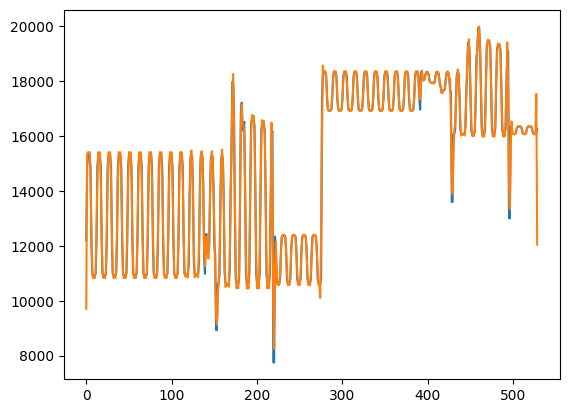

In [21]:
w_l = 2
p_o = 2
data_in = out_data[0:n_s,0:2].copy()
data_filt = apllaySavitzkyGolay(data_in, w_l, p_o)
idx = 0
plt.plot(data_in[:,idx])
plt.plot(data_filt[:,idx])
plt.show()